In [109]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [110]:
%cd /content/gdrive/My Drive/datasets

/content/gdrive/My Drive/datasets


In [111]:
pip install lifetimes

In [112]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [113]:
df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2010-2011")

In [114]:
df = df_.copy()

In [115]:
df.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536368,22960,JAM MAKING SET WITH JARS,6,2010-12-01 08:34:00,4.25,13047.0,United Kingdom


In [116]:
uk_df = df[df['Country'] == 'United Kingdom']

##**Veri hazırlama**

In [117]:
uk_df.dropna(inplace=True)

In [118]:
uk_df = uk_df[~uk_df["Invoice"].str.contains("C", na=False)] # cancel edilmis siparisler cikarildi


In [119]:
uk_df = uk_df[(uk_df['Quantity'] > 0)]

In [120]:
uk_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,354345.0,12.048913,190.428127,1.0,2.00,4.00,12.00,80995.00
Price,354345.0,2.963793,17.862067,0.0,1.25,1.95,3.75,8142.75
Customer ID,354345.0,15552.436219,1594.546025,12346.0,14194.00,15522.00,16931.00,18287.00


In [121]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [122]:
replace_with_thresholds(uk_df, "Quantity")  # outlierları çıkardık 
replace_with_thresholds(uk_df, "Price")

In [123]:
uk_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,354345.0,10.676869,22.075531,1.0,2.00,4.00,12.00,248.50
Price,354345.0,2.815039,2.920551,0.0,1.25,1.95,3.75,31.56
Customer ID,354345.0,15552.436219,1594.546025,12346.0,14194.00,15522.00,16931.00,18287.00


In [124]:
uk_df["TotalPrice"] = uk_df["Quantity"] * uk_df["Price"]

In [125]:
uk_df["InvoiceDate"].max()

Timestamp('2011-12-09 12:49:00')

In [126]:
today_date = dt.datetime(2011, 12, 11) # +2 gün eklendi yeni uyelerde hata almamak icin 

## RFM tablosu

In [127]:
rfm = uk_df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days, # recency 
                                                     lambda date: (today_date - date.min()).days], # tenur
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})


In [128]:
rfm

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0               0        326        1     258.44
12747.0             366        370       11    4196.01
12748.0             372        374      210   32303.91
12749.0             209        214        5    4072.44
12820.0             323        327        4     942.34
...                 ...        ...      ...        ...
18280.0               0        278        1     180.60
18281.0               0        181        1      80.82
18282.0             118        127        2     178.05
18283.0             333        338       16    2094.88
18287.0             158        202        3    1837.28

[3921 rows x 4 columns]

In [129]:
rfm.columns = rfm.columns.droplevel(0)

In [130]:
## recency_cltv_p
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']

In [131]:
# gamma gamma için ortalama monetary_avg
# her bir müşteri her bir faturada ortalama ne kadar harcamış olduğu
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

In [132]:
rfm.rename(columns={"monetary": "monetary_avg"},inplace=True)

In [133]:
rfm

,recency_cltv_p,T,frequency,monetary_avg
Customer ID,,,,
12346.0,0,326,1,258.440000
12747.0,366,370,11,381.455455
12748.0,372,374,210,153.828143
12749.0,209,214,5,814.488000
12820.0,323,327,4,235.585000
...,...,...,...,...
18280.0,0,278,1,180.600000
18281.0,0,181,1,80.820000
18282.0,118,127,2,89.025000


In [134]:
# BGNBD için WEEKLY RECENCY VE WEEKLY T'nin HESAPLANMASI
## recency_weekly_p
rfm["recency_weekly_p"] = rfm["recency_cltv_p"] / 7
rfm["T_weekly"] = rfm["T"] / 7

In [135]:
rfm = rfm[rfm["monetary_avg"] > 0]

In [136]:

## freq > 1
rfm = rfm[(rfm['frequency'] > 1)]
rfm["frequency"] = rfm["frequency"].astype(int)

In [137]:
rfm

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly
Customer ID,,,,,,
12747.0,366,370,11,381.455455,52.285714,52.857143
12748.0,372,374,210,153.828143,53.142857,53.428571
12749.0,209,214,5,814.488000,29.857143,30.571429
12820.0,323,327,4,235.585000,46.142857,46.714286
12822.0,16,88,2,474.440000,2.285714,12.571429
...,...,...,...,...,...,...
18272.0,244,247,6,513.096667,34.857143,35.285714
18273.0,255,258,3,68.000000,36.428571,36.857143
18282.0,118,127,2,89.025000,16.857143,18.142857


In [138]:
rfm_cltv = rfm.copy()

In [139]:
rfm_cltv

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly
Customer ID,,,,,,
12747.0,366,370,11,381.455455,52.285714,52.857143
12748.0,372,374,210,153.828143,53.142857,53.428571
12749.0,209,214,5,814.488000,29.857143,30.571429
12820.0,323,327,4,235.585000,46.142857,46.714286
12822.0,16,88,2,474.440000,2.285714,12.571429
...,...,...,...,...,...,...
18272.0,244,247,6,513.096667,34.857143,35.285714
18273.0,255,258,3,68.000000,36.428571,36.857143
18282.0,118,127,2,89.025000,16.857143,18.142857


In [140]:

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(rfm['frequency'],
        rfm['recency_weekly_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2570 subjects, a: 0.12, alpha: 11.66, b: 2.51, r: 2.21>

In [141]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        rfm['frequency'],
                                                        rfm['recency_weekly_p'],
                                                        rfm['T_weekly']).sort_values(ascending=False).head(10)


Customer ID
12748.0    3.252952
17841.0    1.933252
13089.0    1.532019
14606.0    1.458797
15311.0    1.428625
12971.0    1.352266
13408.0    0.982914
18102.0    0.965291
13798.0    0.908239
14527.0    0.882959
dtype: float64

In [142]:
rfm["expected_number_of_purchases"] = bgf.predict(1,
                                                  rfm['frequency'],
                                                  rfm['recency_weekly_p'],
                                                  rfm['T_weekly'])

rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases
Customer ID,,,,,,,
12747.0,366,370,11,381.455455,52.285714,52.857143,0.202479
12748.0,372,374,210,153.828143,53.142857,53.428571,3.252952
12749.0,209,214,5,814.488000,29.857143,30.571429,0.167149
12820.0,323,327,4,235.585000,46.142857,46.714286,0.103972
12822.0,16,88,2,474.440000,2.285714,12.571429,0.129141


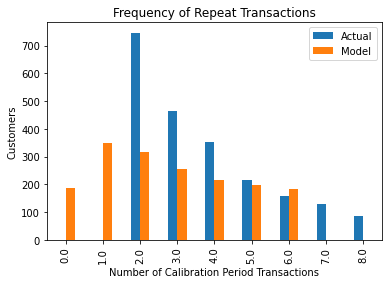

In [143]:
################################################################
# 1 Ay içinde tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################

bgf.predict(4,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

################################################################
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################


bgf.predict(4 * 3,
            rfm['frequency'],
            rfm['recency_weekly_p'],
            rfm['T_weekly']).sum()

################################################################
# Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()

In [144]:

##############################################################
# 3. GAMMA-GAMMA Modelinin Kurulması
##############################################################


ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(rfm['frequency'], rfm['monetary_avg'])

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).head(10)

ggf.conditional_expected_average_profit(rfm['frequency'],
                                        rfm['monetary_avg']).sort_values(ascending=False).head(10)

rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

rfm.sort_values("expected_average_profit", ascending=False).head(15)

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit
Customer ID,,,,,,,,
14088.0,312,323,13,3859.601538,44.571429,46.142857,0.259732,3911.318850
18102.0,366,368,60,3584.887750,52.285714,52.571429,0.965291,3595.192557
14096.0,97,102,17,3159.077059,13.857143,14.571429,0.723053,3191.386734
17511.0,370,374,31,2921.951935,52.857143,53.428571,0.507374,2938.274487
15749.0,97,333,3,2521.446667,13.857143,47.571429,0.028381,2675.118999
17450.0,359,368,46,2629.529891,51.285714,52.571429,0.745075,2639.419342
13081.0,359,372,11,2575.622727,51.285714,53.142857,0.200947,2616.624391
16984.0,41,131,2,2240.675000,5.857143,18.714286,0.103307,2452.124911
16000.0,0,3,3,2055.786667,0.000000,0.428571,0.416012,2181.323596


In [145]:
##############################################################
# 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
##############################################################
# GÖREV 1
##############################################################
# - 2010-2011 UK müşterileri için 6 aylık CLTV prediction yapınız.
# - Elde ettiğiniz sonuçları yorumlayıp üzerinde değerlendirme yapınız.
# - Mantıksız ya da çok isabetli olduğunu düşündüğünüz sonuçları vurgulayınız.
# - Dikkat! 6 aylık expected sales değil cltv prediction yapılmasını bekliyoruz.
#   Yani direk bgnbd ve gamma modellerini kurarak devam ediniz ve
# - cltv prediction için ay bölümüne 6 giriniz.

cltv = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=6,  # 6 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv.head()


Customer ID
12747.0     1937.046140
12748.0    12365.796180
12749.0     3446.010436
12820.0      631.939332
12822.0     1612.096652
Name: clv, dtype: float64

In [146]:
cltv.shape

(2570,)

In [147]:
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False).head(50)

,Customer ID,clv
2486,18102.0,85651.010467
589,14096.0,55650.646773
2184,17450.0,48533.310108
2213,17511.0,36797.006732
1804,16684.0,25083.025410
406,13694.0,25060.708710
587,14088.0,25010.059127
1173,15311.0,23591.389482
133,13089.0,22927.692955
1057,15061.0,21123.082064


In [148]:
rfm_cltv_final = rfm.merge(cltv, on="Customer ID", how="left")
rfm_cltv_final.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.202479,387.822846,1937.046140
1,12748.0,372,374,210,153.828143,53.142857,53.428571,3.252952,153.971325,12365.796180
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.167149,844.094697,3446.010436
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.103972,247.080949,631.939332
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.129141,520.828195,1612.096652


In [149]:

##############################################################
# GÖREV 3
##############################################################
# 2010-2011 UK müşterileri için 6 aylık CLTV'ye göre tüm müşterilerinizi 3 gruba (segmente) ayırınız ve
# grup isimlerini veri setine ekleyiniz. Örneğin (C, B, A)
# CLTV'ye göre en iyi yüzde 20'yi seçiniz. Ve bunlara top_flag yazınız. yüzde 20'ye 1.
# diğerlerine 0 yazınız.

# 3 grubu veri setindeki diğer değişkenler açısıdan analiz ediniz.
# 3 grup için yönetime 6 aylık aksiyon önerilerinde bulununuz. Kısa kısa.

In [150]:
rfm_cltv_final["segment"] = pd.qcut(rfm_cltv_final["clv"], 3, labels=["C", "B", "A"])
rfm_cltv_final = rfm_cltv_final.sort_values(by="clv", ascending=False)
rfm_cltv_final=rfm_cltv_final.reset_index()
rfm_cltv_final.head()

,index,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv,segment
0,2486,18102.0,366,368,60,3584.887750,52.285714,52.571429,0.965291,3595.192557,85651.010467,A
1,589,14096.0,97,102,17,3159.077059,13.857143,14.571429,0.723053,3191.386734,55650.646773,A
2,2184,17450.0,359,368,46,2629.529891,51.285714,52.571429,0.745075,2639.419342,48533.310108,A
3,2213,17511.0,370,374,31,2921.951935,52.857143,53.428571,0.507374,2938.274487,36797.006732,A
4,1804,16684.0,353,359,28,2120.046964,50.428571,51.285714,0.476683,2133.203588,25083.025410,A


In [151]:
rfm_cltv_final["segment"].value_counts()

A    857
C    857
B    856
Name: segment, dtype: int64

In [152]:
len(rfm_cltv_final)


2570

In [153]:
(rfm_cltv_final.shape[0] *0.20)

514.0

In [154]:
rfm_cltv_final["top_flag"] = 0
rfm_cltv_final["top_flag"].iloc[0:515] = 1

In [155]:
##############################################################
# GÖREV 2
##############################################################
# - 2010-2011 UK müşterileri için 1 aylık ve 12 aylık CLTV hesaplayınız.
# - 1 aylık CLTV'de en yüksek olan 10 kişi ile 12 aylık'taki en yüksek 10 kişiyi analiz ediniz.
# - Fark var mı? Varsa sizce neden olabilir?
# Dikkat! Sıfırdan model kurulmasına gerek yoktur.
# Var olan bgf ve ggf üzerinden direk cltv hesaplanabilir.


In [156]:
cltv_1 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=1,  # 1 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv_1.head()

Customer ID
12747.0     336.778826
12748.0    2148.375671
12749.0     604.071001
12820.0     110.124851
12822.0     286.922336
Name: clv, dtype: float64

In [157]:
cltv_1 = cltv_1.reset_index()
cltv_1.sort_values(by="clv", ascending=False).head(10)

,Customer ID,clv
2486,18102.0,14884.974999
589,14096.0,9855.879890
2184,17450.0,8434.764722
2213,17511.0,6394.324321
1804,16684.0,4361.053957
587,14088.0,4355.485259
406,13694.0,4354.468531
1173,15311.0,4098.869447
133,13089.0,3984.051505
1485,16000.0,3843.979499


In [158]:
rfm_cltv_final_1 = rfm.merge(cltv_1, on="Customer ID", how="left")
rfm_cltv_final_1.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.202479,387.822846,336.778826
1,12748.0,372,374,210,153.828143,53.142857,53.428571,3.252952,153.971325,2148.375671
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.167149,844.094697,604.071001
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.103972,247.080949,110.124851
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.129141,520.828195,286.922336


In [162]:
cltv_12 = ggf.customer_lifetime_value(bgf,
                                   rfm['frequency'],
                                   rfm['recency_weekly_p'],
                                   rfm['T_weekly'],
                                   rfm['monetary_avg'],
                                   time=12,  # 12 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

cltv_12.head()

Customer ID
12747.0     3698.381136
12748.0    23623.996889
12749.0     6538.827675
12820.0     1204.326224
12822.0     3029.794538
Name: clv, dtype: float64

In [163]:
cltv_12 = cltv_12.reset_index()
cltv_12.sort_values(by="clv", ascending=False).head(20)

,Customer ID,clv
2486,18102.0,163591.126764
589,14096.0,104900.442916
2184,17450.0,92694.274819
2213,17511.0,70285.652300
1804,16684.0,47890.364207
406,13694.0,47871.899999
587,14088.0,47688.863650
1173,15311.0,45067.809393
133,13089.0,43795.472864
1057,15061.0,40348.816688


In [164]:
rfm_cltv_final_12 = rfm.merge(cltv_12, on="Customer ID", how="left")
rfm_cltv_final_12.head()

,Customer ID,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_p,T_weekly,expected_number_of_purchases,expected_average_profit,clv
0,12747.0,366,370,11,381.455455,52.285714,52.857143,0.202479,387.822846,3698.381136
1,12748.0,372,374,210,153.828143,53.142857,53.428571,3.252952,153.971325,23623.996889
2,12749.0,209,214,5,814.488000,29.857143,30.571429,0.167149,844.094697,6538.827675
3,12820.0,323,327,4,235.585000,46.142857,46.714286,0.103972,247.080949,1204.326224
4,12822.0,16,88,2,474.440000,2.285714,12.571429,0.129141,520.828195,3029.794538
